In [1]:
# IMPORTING LIBRARIES 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [2]:
# IMPORTING DATASET
data = pd.read_excel("Data.xlsx")

In [ ]:
#Creating a seperate test set for the outliers 
#Seperating entries where Gross Turnover and Discount Total are zero for predicting with champion model
#It is assumed that the entries where product volume is positive and discount offered is zero indicate underfitting of
#of total discount. 
S1 = data[data['Discount_Total']>data['Discount_Total'].std()*3]
S2 = data[data['Discount Percentage ']>data['Discount Percentage '].std()*3]
S3 = data[data['GTO_2019']>data['GTO_2019'].std()*3]
S4 = data[data['Discount_Total']<=0]
S5 = data[data['GTO_2019']<=0]
ts1 = S1.append(S2)
ts2 = ts1.append(S3)
ts3 = ts2.append(S4)
Test_Set = ts3.append(S5)
Test_Set = Test_Set.drop_duplicates()

In [4]:
print(data.dtypes)

Ship-to ID                    int64
Volume_2019                 float64
Volume_2018                 float64
sfdc_tier                    object
poc_image                    object
segment                      object
sub_segment                  object
Product_Set                  object
Brand                        object
Sub_Brand                    object
Pack_Type                    object
Returnalility                object
GTO_2019                    float64
OnInvoice Discount(LCU)     float64
OffInvoice Discount(LCU)    float64
Volume_2019_Product         float64
Tax                         float64
province                     object
Discount_Total              float64
Discount Percentage         float64
dtype: object


In [5]:
#Removing the outliers and negative values
data = data[data['Discount_Total']<data['Discount_Total'].std()*3]
data = data[data['Discount Percentage ']<data['Discount Percentage '].std()*3]
data = data[data['GTO_2019']<data['GTO_2019'].std()*3]
data = data[data['Discount_Total']>0]
data = data[data['GTO_2019']>0]

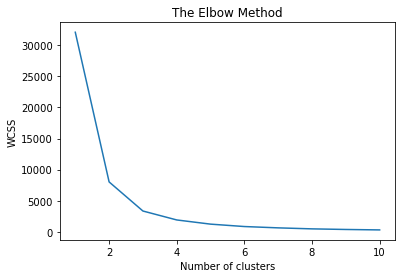

In [6]:
#METHOD 1
#K means clustering model
#Clustering is done on the basis on the basis of product set volume to group customers on the basis of order volumes
v = data['Volume_2019_Product']
v = data['Volume_2019_Product']
v = pd.DataFrame(v)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(v)
V = scaler.transform(v)

from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(V)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(V)
data['Cluster'] = pd.Series(y_kmeans, index=data.index)

In [7]:
#Clusters generated from K-means clustering algorithm are treated as categorical variable and encoded as dummy variables 
X0 = data[['sfdc_tier', 'sub_segment', 'Cluster', 'Volume_2019_Product']]
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2])], 
                        remainder='passthrough')
x0 = np.array(ct.fit_transform(X0))
x0 = pd.DataFrame(x0)
x0.columns = ['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'sfdc_tier',
              'sub_segment', 'Volume_2019_Product']
dummies0 = pd.get_dummies(data = x0 [['sfdc_tier', 'sub_segment']])
vol = x0[['Volume_2019_Product', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4']]
X0 = pd.concat([vol, dummies0], axis =1)
X0 = X0.astype(float)
Y = data['Discount_Total']
Y0 = pd.Series.reset_index(Y)
Y0 = Y0.drop(['index'], axis =1)
Y0 = Y0.astype(float)

In [8]:
#dataset splitting 
from sklearn.model_selection import train_test_split
x0_train, x0_test, y0_train, y0_test = train_test_split(X0, Y0, test_size = 0.2, random_state = 0)

In [9]:
#Linear Regression Model (Model 0.1)
model0 = sm.OLS(y0_train,x0_train).fit()
print(model0.summary())
Y_pred00 = model0.predict(x0_train)
YP00 = model0.predict(x0_test)

                            OLS Regression Results                            
Dep. Variable:         Discount_Total   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     2875.
Date:                Sun, 09 May 2021   Prob (F-statistic):               0.00
Time:                        01:23:56   Log-Likelihood:            -1.9325e+05
No. Observations:               25656   AIC:                         3.865e+05
Df Residuals:                   25635   BIC:                         3.867e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Volume_2019_Product 

In [10]:
#Random Forest Regression model (Model 0.2)
from sklearn.ensemble import RandomForestRegressor
regressor0 = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor0.fit(x0_train, y0_train)
Y_pred01 = regressor0.predict(x0_train)
YP01 = regressor0.predict(x0_test)

<ipython-input-10-ad552c7cd082>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor0.fit(x0_train, y0_train)


In [11]:
#LASSO regression model (Model 0.3)
model0_3 = Lasso()
model0_3.fit(x0_train, y0_train)
Y_pred02 = model0_3.predict(x0_train)
YP02 = model0_3.predict(x0_test)

In [12]:
#Ridge Regression model (Model 0.4)
model0_4 = Ridge()
model0_4.fit(x0_train, y0_train)
Y_pred03 = model0_4.predict(x0_train)
YP03 = model0_4.predict(x0_test)

In [13]:
#METHOD 2
#Model with all the variables included 
#Creating Dummy variables and X & Y
X = data[['sfdc_tier', 'poc_image', 'sub_segment', 'Product_Set','Volume_2019_Product']]
dummies = pd.get_dummies(X[['sfdc_tier', 'poc_image', 'sub_segment','Product_Set']])
X = data['Volume_2019_Product']
X = pd.concat([X, dummies], axis=1)
X.info()
Y = data['Discount_Total']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32071 entries, 3 to 39854
Columns: 157 entries, Volume_2019_Product to Product_Set_RETURNABLE_PERFECTDRAFT_TRIPEL KARMELIET_TRIPEL KARMELIET
dtypes: float64(1), uint8(156)
memory usage: 5.3 MB


In [14]:
#Splitting the data into training set and validation set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [15]:
#Linear Regression Model (Model 1.1)
model = sm.OLS(y_train,x_train).fit()
print(model.summary())
Y_pred1 = model.predict(x_train)
YP1 = model.predict(x_test)

                            OLS Regression Results                            
Dep. Variable:         Discount_Total   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     403.8
Date:                Sun, 09 May 2021   Prob (F-statistic):               0.00
Time:                        01:24:22   Log-Likelihood:            -1.9268e+05
No. Observations:               25656   AIC:                         3.857e+05
Df Residuals:                   25504   BIC:                         3.869e+05
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [16]:
#Random Forest Regression model (Model 1.2)
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(x_train, y_train)
Y_pred2 = regressor.predict(x_train)
YP2 = regressor.predict(x_test)

In [17]:
#LASSO regression model (Model 1.3)
model_3 = Lasso()
model_3.fit(x_train, y_train)
Y_pred3 = model_3.predict(x_train)
YP3 = model_3.predict(x_test)

In [18]:
#Ridge Regression model (Model 1.4)
model_4 = Ridge()
model_4.fit(x_train, y_train)
Y_pred4 = model_4.predict(x_train)
YP4 = model_4.predict(x_test)

In [19]:
#Parametric Evaluation of Models 
#Method 1
#training set
mt00 = mse(y0_train, Y_pred00)
mt01 = mse(y0_train, Y_pred01)
mt02 = mse(y0_train, Y_pred02)
mt03 = mse(y0_train, Y_pred03)
rt00 = r2_score(y0_train, Y_pred00)
rt01 = r2_score(y0_train, Y_pred01)
rt02 = r2_score(y0_train, Y_pred01)
rt03 = r2_score(y0_train, Y_pred03)
#test set
mtt00 = mse(y0_test, YP00)
mtt01 = mse(y0_test, YP01)
mtt02 = mse(y0_test, YP02)
mtt03 = mse(y0_test, YP03)
rtt00 = r2_score(y0_test, YP00)
rtt01 = r2_score(y0_test, YP01)
rtt02 = r2_score(y0_test, YP01)
rtt03 = r2_score(y0_test, YP03)

In [20]:
#Method 2
#training set
mt1 = mse(y_train, Y_pred1)
mt2 = mse(y_train, Y_pred2)
mt3 = mse(y_train, Y_pred3)
mt4 = mse(y_train, Y_pred4)
rt1= r2_score(y_train, Y_pred1)
rt2 = r2_score(y_train, Y_pred2)
rt3 = r2_score(y_train, Y_pred3)
rt4 = r2_score(y_train, Y_pred4)
#test set
mtt1 = mse(y_test, YP1)
mtt2 = mse(y_test, YP2)
mtt3 = mse(y_test, YP3)
mtt4 = mse(y_test, YP4)
rtt1 = r2_score(y_test, YP1)
rtt2 = r2_score(y_test, YP2)
rtt3 = r2_score(y_test, YP3)
rtt4 = r2_score(y_test, YP4)

In [21]:
print([mt00, mt01, mt02, mt03, rt00, rt01, rt02, rt03,
      mtt00, mtt01, mtt02, mtt03, rtt00, rtt01, rtt02, rtt03,
      mt1, mt2, mt3, mt4, rt1, rt2, rt3, rt4,
      mtt1, mtt2, mtt3, mtt4, rtt1, rtt2, rtt3, rtt4])

[204234.95350130738, 56780.61814935907, 204762.94159330617, 204235.27460569973, 0.6916183510079383, 0.9142649171676882, 0.9142649171676882, 0.6916178661609504, 189124.13778200286, 218445.49964606555, 189964.3720176113, 189123.88802340976, 0.717372442799774, 0.673554530530024, 0.673554530530024, 0.717372816039604, 195333.39518057054, 41541.3584763042, 197545.02856682107, 195390.21965920104, 0.7050591317679773, 0.9372752195024685, 0.701719707546386, 0.7049733304586383, 191097.06947535963, 180836.51743231775, 192296.5223701002, 190985.5298719762, 0.7144240890277184, 0.7297574821813377, 0.7126316237951311, 0.714590774073874]


In [22]:
# #Feature Engineering new data to fit into champion  models (Random Forest regression model under Method 2)
xt = Test_Set[['sfdc_tier', 'poc_image', 'sub_segment','Product_Set','Volume_2019_Product']]
dummies2 = pd.get_dummies(xt[['sfdc_tier', 'poc_image', 'sub_segment', 'Product_Set']])
xt_1 = Test_Set['Volume_2019_Product']
xt = pd.concat([xt_1, dummies2], axis=1)
xt.info()
xtt = pd.DataFrame(data = xt, columns = X.columns)
x_test = xtt.fillna(0)

test_pred = regressor.predict(x_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7189 entries, 998 to 39505
Columns: 157 entries, Volume_2019_Product to Product_Set_RETURNABLE_PERFECTDRAFT_TRIPEL KARMELIET_TRIPEL KARMELIET
dtypes: float64(1), uint8(156)
memory usage: 1.2 MB


In [23]:
#Consolidating the predictions for Total Discount 
Discount_Predictions = regressor.predict(X)
data['Discount_Predictions'] = pd.Series(Discount_Predictions, index=data.index)
Test_Set['Discount_Predictions'] = pd.Series(test_pred, index = Test_Set.index)
Output = pd.concat([data, Test_Set])

In [24]:
#Treatment of off-invoice
off_invoice = Output['OffInvoice Discount(LCU)']
X2 = Output[['Volume_2019_Product', 'Discount_Total']]
X2_predict = Output[['Volume_2019_Product', 'Discount_Predictions']]
#Random Forest Regression model
regressor2 = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor2.fit(X2, off_invoice)
predict2 = regressor2.predict(X2_predict)
Output['Offinvoice discount_pred'] = pd.Series(predict2, index = Output.index)
Output.to_csv('Output.csv', header=True, index=False)